## Visualizing Caltrain Ridership - 2016 Weekday Average

This notebook contains a set of timetable visualizations built with open data published by Caltrain. You can [view the project](https://github.com/invisiblefunnel/learning/blob/master/2016%20Caltrain%20Weekday%20Ridership%20Timetables.ipynb)  on GitHub.

- [GTFS feed](http://transitfeeds.com/p/caltrain/122/20160818)
- [2016 Annual Passenger Counts by Train – Weekdays](http://www.caltrain.com/Assets/_Marketing/caltrain/xls/2016/2016+Annual+Passenger+Counts+by+Train+$!e2$!80$!93+Weekdays.xls)

In [1]:
from collections import defaultdict
import datetime
from ipy_table import make_table
from itertools import tee
import networkx as nx
from nxpd import draw
import pandas as pd
import partridge as ptg

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2,s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def transpose(list_of_lists):
    return list(map(list, zip(*list_of_lists)))

def fmttime(ssm):
    # credit: https://git.io/v5t8P
    if ssm is None:
        return ""
    h = ssm / 3600
    ssm %= 3600
    m = ssm / 60
    ssm %= 60
    s = ssm
    return "%02d:%02d:%02d" % (h, m, s)

In [2]:
path = 'data/Caltrain-2016-08-18.zip'
date = datetime.date(2016, 6, 8)

service_ids_by_date = ptg.read_service_ids_by_date(path)
feed = ptg.feed(path, view={
    'trips.txt': {
        'service_id': service_ids_by_date[date],
        'direction_id': '1',
        'route_id': [
            'Bu-16APR', # Baby Bullet
            'Li-16APR', # Limited
            'Lo-16APR', # Local
        ]
    },
})

stop_names = dict(feed.stops[['stop_id', 'stop_name']].as_matrix())
trip_names = dict(feed.trips[['trip_id', 'trip_short_name']].as_matrix())

In [3]:
patterns = set()
trip_start_times = []

for trip_id, stimes in feed.stop_times.sort_values('stop_sequence').groupby('trip_id'):
    pattern = tuple(stimes.stop_id)
    patterns.add(pattern)
    trip_start_times.append((trip_id, stimes.iloc[0].arrival_time))

In [4]:
G = nx.DiGraph()

# Build a pattern graph
for pattern in patterns:
    for a, b in pairwise(pattern):
        G.add_edge(a, b)

# Label nodes with stop names
for stop_id, data in G.nodes(data=True):
    data["label"] = stop_names[stop_id].split("Caltrain")[0].strip()

In [5]:
df = pd.read_csv("./data/2016 Average Weekday Passenger Counts by Train.csv")

ridership = {}
for _, row in df.iterrows():
    trip_short_name = str(row["trip_short_name"])
    stop_name = row["stop_name"]
    if trip_short_name not in ridership:
        ridership[trip_short_name] = {}
    ridership[trip_short_name][stop_name] = dict(row)

In [6]:
# This only works if the patterns form a directed-acyclic graph
header = [G.node[stop_id]["label"] for stop_id in nx.topological_sort(G)]
trip_ordering = [trip_id for trip_id, start in sorted(trip_start_times, key=lambda p: p[1])]

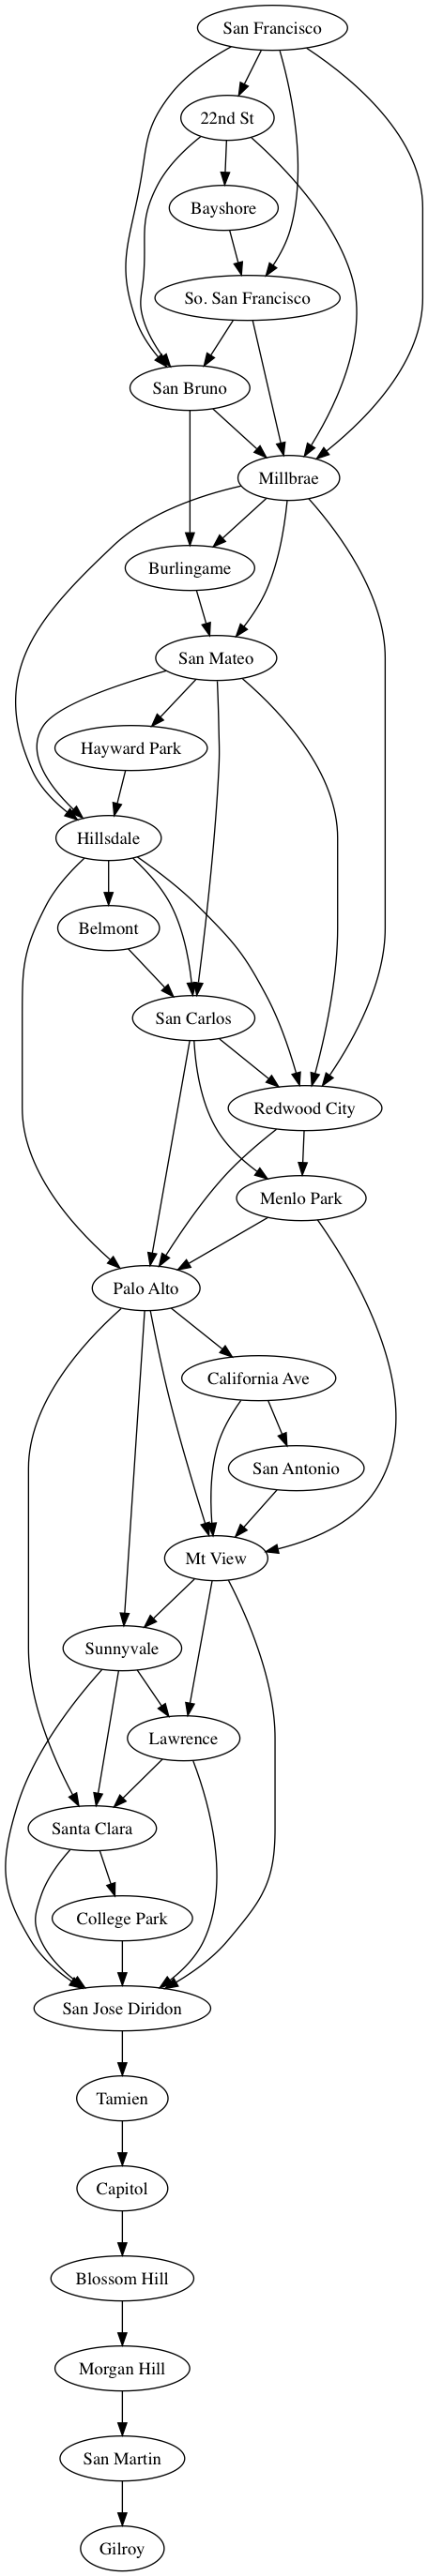

In [7]:
draw(G, show='ipynb')

In [8]:
def build_trip_row(trip_name, stimes, cell_func):
    row = [trip_name]
    stop_ridership = ridership[trip_name]
    # assumes one visit per stop
    stimes_by_stop_name = {G.node[st.stop_id]["label"]: st for _, st in stimes.iterrows()}
    for stop_name in header:
        if stop_name in stop_ridership and stop_name in stimes_by_stop_name:
            stime = stimes_by_stop_name[stop_name]
            riders = stop_ridership[stop_name]
            value = cell_func(stime, riders)
            row.append(value or "-")
        else:
            row.append("-")
    return row

def build_trip_rows(cell_func):
    rows = []
    for trip_id in trip_ordering:
        stimes = feed.stop_times[feed.stop_times.trip_id==trip_id].sort_values('stop_sequence')
        trip_name = trip_names[trip_id]
        if trip_name not in ridership:
            continue
        rows.append(build_trip_row(trip_name, stimes, cell_func))
    return rows

def build_timetable(cell_func):
    return [[""]+header] + build_trip_rows(cell_func)

## Timetable

In [9]:
def stop_time(stime, riders):
    return fmttime(stime.arrival_time or stime.departure_time)

make_table(transpose(build_timetable(stop_time)))

,102,104,206,208,210,312,314,216,218,220,322,324,226,228,230,332,134,236,138,142,146,150,152,254,156,258,360,262,264,366,268,370,272,274,376,278,380,282,284,386,288,190,192,194,196,198
San Francisco,04:55:00,05:25:00,06:06:00,06:24:00,06:44:00,06:56:00,07:12:00,07:19:00,07:24:00,07:44:00,07:56:00,08:12:00,08:19:00,08:24:00,08:44:00,08:56:00,09:00:00,09:37:00,10:00:00,11:00:00,12:00:00,13:00:00,14:00:00,14:37:00,15:00:00,15:37:00,16:10:00,16:19:00,16:28:00,16:33:00,16:55:00,17:12:00,17:20:00,17:28:00,17:33:00,17:55:00,18:12:00,18:20:00,18:28:00,18:33:00,18:55:00,19:33:00,20:40:00,21:40:00,22:40:00,24:01:00
22nd St,05:00:00,05:30:00,06:11:00,06:29:00,06:50:00,07:02:00,07:18:00,07:25:00,07:29:00,07:50:00,08:02:00,08:18:00,08:25:00,08:29:00,08:50:00,09:02:00,09:05:00,-,10:05:00,11:05:00,12:05:00,13:05:00,14:05:00,-,15:05:00,-,-,-,16:33:00,-,-,-,-,17:33:00,-,-,-,-,18:33:00,-,-,19:38:00,20:45:00,21:45:00,22:45:00,24:06:00
Bayshore,05:05:00,05:35:00,-,06:35:00,-,-,-,-,07:35:00,-,-,-,-,08:35:00,-,-,09:10:00,-,10:10:00,11:10:00,12:10:00,13:10:00,14:10:00,-,15:12:00,-,-,-,16:41:00,-,-,-,-,17:41:00,-,-,-,-,18:41:00,-,-,19:43:00,20:50:00,21:50:00,22:50:00,24:11:00
So. San Francisco,05:11:00,05:41:00,-,06:41:00,-,-,-,-,07:41:00,-,-,-,-,08:41:00,-,-,09:15:00,-,10:15:00,11:15:00,12:15:00,13:15:00,14:15:00,-,15:17:00,-,-,-,16:49:00,-,17:08:00,-,-,17:49:00,-,18:08:00,-,-,18:49:00,-,19:08:00,19:49:00,20:56:00,21:56:00,22:56:00,24:17:00
San Bruno,05:15:00,05:45:00,-,06:44:00,-,-,-,07:37:00,07:44:00,-,-,-,08:37:00,08:44:00,-,-,09:18:00,09:52:00,10:18:00,11:18:00,12:18:00,13:18:00,14:18:00,14:52:00,15:21:00,15:52:00,-,16:33:00,16:53:00,-,-,-,17:35:00,17:53:00,-,-,-,18:35:00,18:53:00,-,-,19:53:00,21:00:00,22:00:00,23:00:00,24:21:00
Millbrae,05:19:00,05:49:00,06:24:00,06:49:00,07:02:00,07:17:00,07:32:00,-,07:49:00,08:02:00,08:17:00,08:32:00,-,08:49:00,09:02:00,09:17:00,09:22:00,09:56:00,10:22:00,11:22:00,12:22:00,13:22:00,14:22:00,14:56:00,15:25:00,15:56:00,16:26:00,-,16:57:00,16:50:00,17:14:00,17:30:00,-,17:57:00,17:50:00,18:14:00,18:30:00,-,18:57:00,18:50:00,19:14:00,19:57:00,21:05:00,22:05:00,23:05:00,24:25:00
Burlingame,05:23:00,05:53:00,06:28:00,06:53:00,-,-,-,07:44:00,07:53:00,-,-,-,08:44:00,08:53:00,-,-,09:27:00,10:01:00,10:27:00,11:27:00,12:27:00,13:27:00,14:27:00,15:01:00,15:30:00,16:01:00,-,16:38:00,17:01:00,-,-,-,17:42:00,18:01:00,-,-,-,18:42:00,19:01:00,-,-,20:01:00,21:09:00,22:09:00,23:09:00,24:29:00
San Mateo,05:28:00,05:58:00,06:32:00,06:56:00,07:09:00,-,-,07:48:00,07:56:00,08:09:00,-,-,08:48:00,08:56:00,09:09:00,-,09:30:00,10:04:00,10:30:00,11:30:00,12:30:00,13:30:00,14:30:00,15:04:00,15:33:00,16:04:00,-,16:43:00,17:06:00,16:59:00,-,-,17:45:00,18:06:00,17:59:00,-,-,18:45:00,19:06:00,18:59:00,-,20:06:00,21:13:00,22:13:00,23:13:00,24:34:00
Hayward Park,05:31:00,06:01:00,-,07:00:00,-,-,-,-,08:00:00,-,-,-,-,09:00:00,-,-,09:33:00,-,10:33:00,11:33:00,12:33:00,13:33:00,14:33:00,-,15:36:00,-,-,-,17:09:00,-,-,-,-,18:09:00,-,-,-,-,19:09:00,-,-,20:09:00,21:16:00,22:16:00,23:16:00,24:37:00
Hillsdale,05:34:00,06:04:00,06:36:00,07:04:00,-,-,07:42:00,07:52:00,08:04:00,-,-,08:42:00,08:52:00,09:04:00,-,-,09:37:00,10:08:00,10:37:00,11:37:00,12:37:00,13:37:00,14:37:00,15:08:00,15:40:00,16:08:00,16:36:00,16:48:00,17:13:00,-,17:24:00,17:40:00,17:50:00,18:13:00,-,18:24:00,18:40:00,18:50:00,19:13:00,-,19:24:00,20:12:00,21:20:00,22:20:00,23:20:00,24:40:00


## Boardings

In [10]:
def boardings(stime, riders): return round(riders["boardings"])

make_table(transpose(build_timetable(boardings)))

,102,104,206,208,210,312,314,216,218,220,322,324,226,228,230,332,134,236,138,142,146,150,152,254,156,258,360,262,264,366,268,370,272,274,376,278,380,282,284,386,288,190,192,194,196,198
San Francisco,17,24,112,33,181,219,306,161,83,425,397,357,193,142,369,367,154,254,188,179,151,169,175,192,158,277,490,394,109,618,614,791,727,225,886,780,697,523,136,604,559,429,407,242,171,83
22nd St,7,9,57,17,96,117,144,64,25,140,144,143,79,33,142,143,55,-,45,22,18,11,12,-,11,-,-,-,21,-,-,-,-,30,-,-,-,-,20,-,-,17,19,10,12,7
Bayshore,4,4,-,19,-,-,-,-,36,-,-,-,-,31,-,-,22,-,12,8,9,8,8,-,11,-,-,-,13,-,-,-,-,8,-,-,-,-,5,-,-,4,4,3,2,1
So. San Francisco,6,8,-,9,-,-,-,-,20,-,-,-,-,15,-,-,9,-,6,5,5,6,10,-,20,-,-,-,40,-,44,-,-,33,-,18,-,-,11,-,7,6,4,3,3,1
San Bruno,6,8,-,26,-,-,-,55,29,-,-,-,33,18,-,-,17,10,15,5,11,9,13,8,10,15,-,14,17,-,-,-,30,12,-,-,-,19,8,-,-,5,5,5,3,2
Millbrae,8,36,84,59,83,157,115,-,89,115,129,117,-,72,90,78,74,59,70,66,48,64,63,43,83,79,87,-,88,103,67,79,-,92,110,82,53,-,61,62,43,68,43,35,26,15
Burlingame,4,11,22,24,-,-,-,66,47,-,-,-,40,35,-,-,25,12,12,12,9,11,9,9,12,11,-,19,24,-,-,-,25,13,-,-,-,15,9,-,-,9,8,6,3,1
San Mateo,7,19,32,26,131,-,-,69,31,82,-,-,64,22,50,-,26,19,19,13,18,15,15,13,59,25,-,23,34,42,-,-,44,30,60,-,-,27,14,22,-,17,15,15,7,6
Hayward Park,3,10,-,21,-,-,-,-,26,-,-,-,-,18,-,-,8,-,7,3,6,8,11,-,13,-,-,-,36,-,-,-,-,19,-,-,-,-,7,-,-,2,5,2,1,1
Hillsdale,8,10,37,39,-,-,114,69,56,-,-,88,37,37,-,-,32,10,12,12,16,13,12,9,80,14,47,28,80,-,37,33,30,46,-,43,30,15,18,-,12,14,12,5,2,-


## Alightings

In [11]:
def alightings(stime, riders): return round(riders["alightings"])

make_table(transpose(build_timetable(alightings)))

,102,104,206,208,210,312,314,216,218,220,322,324,226,228,230,332,134,236,138,142,146,150,152,254,156,258,360,262,264,366,268,370,272,274,376,278,380,282,284,386,288,190,192,194,196,198
San Francisco,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
22nd St,-,-,1,-,-,3,1,-,2,3,1,2,-,-,2,1,3,-,1,-,-,-,-,-,1,-,-,-,3,-,-,-,-,2,-,-,-,-,1,-,-,1,1,-,1,-
Bayshore,-,-,-,-,-,-,-,-,2,-,-,-,-,3,-,-,1,-,-,-,-,1,-,-,1,-,-,-,2,-,-,-,-,11,-,-,-,-,9,-,-,6,2,2,-,-
So. San Francisco,-,3,-,4,-,-,-,-,19,-,-,-,-,32,-,-,11,-,5,2,3,3,4,-,10,-,-,-,12,-,13,-,-,15,-,16,-,-,10,-,7,7,6,3,2,2
San Bruno,-,1,-,1,-,-,-,8,3,-,-,-,21,4,-,-,3,3,5,4,5,8,4,7,5,11,-,32,12,-,-,-,70,12,-,-,-,42,7,-,-,15,17,7,1,2
Millbrae,2,1,4,4,5,8,11,-,8,16,6,7,-,9,12,12,5,3,5,4,7,4,5,10,6,17,18,-,5,36,31,41,-,9,69,50,44,-,9,43,35,23,17,9,5,1
Burlingame,-,2,1,3,-,-,-,17,11,-,-,-,19,12,-,-,17,12,12,5,9,12,9,9,13,15,-,32,20,-,-,-,98,30,-,-,-,83,26,-,-,38,16,13,8,5
San Mateo,1,2,5,11,13,-,-,20,15,53,-,-,53,25,56,-,31,24,18,18,12,17,27,15,18,26,-,54,14,44,-,-,122,22,91,-,-,104,14,72,-,45,29,13,11,8
Hayward Park,-,4,-,9,-,-,-,-,20,-,-,-,-,24,-,-,22,-,11,8,5,6,5,-,6,-,-,-,17,-,-,-,-,28,-,-,-,-,18,-,-,8,11,5,3,4
Hillsdale,1,1,13,11,-,-,76,31,30,-,-,62,23,31,-,-,27,18,17,15,15,19,23,25,28,36,95,47,48,-,154,149,74,50,-,183,144,60,37,-,110,47,41,23,13,7


## Boardings and alightings

In [12]:
def boardings_and_alightings(stime, riders):
    return "+%d/-%d" % (round(riders["boardings"]), round(riders["alightings"]))

make_table(transpose(build_timetable(boardings_and_alightings)))

,102,104,206,208,210,312,314,216,218,220,322,324,226,228,230,332,134,236,138,142,146,150,152,254,156,258,360,262,264,366,268,370,272,274,376,278,380,282,284,386,288,190,192,194,196,198
San Francisco,+17/-0,+24/-0,+112/-0,+33/-0,+181/-0,+219/-0,+306/-0,+161/-0,+83/-0,+425/-0,+397/-0,+357/-0,+193/-0,+142/-0,+369/-0,+367/-0,+154/-0,+254/-0,+188/-0,+179/-0,+151/-0,+169/-0,+175/-0,+192/-0,+158/-0,+277/-0,+490/-0,+394/-0,+109/-0,+618/-0,+614/-0,+791/-0,+727/-0,+225/-0,+886/-0,+780/-0,+697/-0,+523/-0,+136/-0,+604/-0,+559/-0,+429/-0,+407/-0,+242/-0,+171/-0,+83/-0
22nd St,+7/-0,+9/-0,+57/-1,+17/-0,+96/-0,+117/-3,+144/-1,+64/-0,+25/-2,+140/-3,+144/-1,+143/-2,+79/-0,+33/-0,+142/-2,+143/-1,+55/-3,-,+45/-1,+22/-0,+18/-0,+11/-0,+12/-0,-,+11/-1,-,-,-,+21/-3,-,-,-,-,+30/-2,-,-,-,-,+20/-1,-,-,+17/-1,+19/-1,+10/-0,+12/-1,+7/-0
Bayshore,+4/-0,+4/-0,-,+19/-0,-,-,-,-,+36/-2,-,-,-,-,+31/-3,-,-,+22/-1,-,+12/-0,+8/-0,+9/-0,+8/-1,+8/-0,-,+11/-1,-,-,-,+13/-2,-,-,-,-,+8/-11,-,-,-,-,+5/-9,-,-,+4/-6,+4/-2,+3/-2,+2/-0,+1/-0
So. San Francisco,+6/-0,+8/-3,-,+9/-4,-,-,-,-,+20/-19,-,-,-,-,+15/-32,-,-,+9/-11,-,+6/-5,+5/-2,+5/-3,+6/-3,+10/-4,-,+20/-10,-,-,-,+40/-12,-,+44/-13,-,-,+33/-15,-,+18/-16,-,-,+11/-10,-,+7/-7,+6/-7,+4/-6,+3/-3,+3/-2,+1/-2
San Bruno,+6/-0,+8/-1,-,+26/-1,-,-,-,+55/-8,+29/-3,-,-,-,+33/-21,+18/-4,-,-,+17/-3,+10/-3,+15/-5,+5/-4,+11/-5,+9/-8,+13/-4,+8/-7,+10/-5,+15/-11,-,+14/-32,+17/-12,-,-,-,+30/-70,+12/-12,-,-,-,+19/-42,+8/-7,-,-,+5/-15,+5/-17,+5/-7,+3/-1,+2/-2
Millbrae,+8/-2,+36/-1,+84/-4,+59/-4,+83/-5,+157/-8,+115/-11,-,+89/-8,+115/-16,+129/-6,+117/-7,-,+72/-9,+90/-12,+78/-12,+74/-5,+59/-3,+70/-5,+66/-4,+48/-7,+64/-4,+63/-5,+43/-10,+83/-6,+79/-17,+87/-18,-,+88/-5,+103/-36,+67/-31,+79/-41,-,+92/-9,+110/-69,+82/-50,+53/-44,-,+61/-9,+62/-43,+43/-35,+68/-23,+43/-17,+35/-9,+26/-5,+15/-1
Burlingame,+4/-0,+11/-2,+22/-1,+24/-3,-,-,-,+66/-17,+47/-11,-,-,-,+40/-19,+35/-12,-,-,+25/-17,+12/-12,+12/-12,+12/-5,+9/-9,+11/-12,+9/-9,+9/-9,+12/-13,+11/-15,-,+19/-32,+24/-20,-,-,-,+25/-98,+13/-30,-,-,-,+15/-83,+9/-26,-,-,+9/-38,+8/-16,+6/-13,+3/-8,+1/-5
San Mateo,+7/-1,+19/-2,+32/-5,+26/-11,+131/-13,-,-,+69/-20,+31/-15,+82/-53,-,-,+64/-53,+22/-25,+50/-56,-,+26/-31,+19/-24,+19/-18,+13/-18,+18/-12,+15/-17,+15/-27,+13/-15,+59/-18,+25/-26,-,+23/-54,+34/-14,+42/-44,-,-,+44/-122,+30/-22,+60/-91,-,-,+27/-104,+14/-14,+22/-72,-,+17/-45,+15/-29,+15/-13,+7/-11,+6/-8
Hayward Park,+3/-0,+10/-4,-,+21/-9,-,-,-,-,+26/-20,-,-,-,-,+18/-24,-,-,+8/-22,-,+7/-11,+3/-8,+6/-5,+8/-6,+11/-5,-,+13/-6,-,-,-,+36/-17,-,-,-,-,+19/-28,-,-,-,-,+7/-18,-,-,+2/-8,+5/-11,+2/-5,+1/-3,+1/-4
Hillsdale,+8/-1,+10/-1,+37/-13,+39/-11,-,-,+114/-76,+69/-31,+56/-30,-,-,+88/-62,+37/-23,+37/-31,-,-,+32/-27,+10/-18,+12/-17,+12/-15,+16/-15,+13/-19,+12/-23,+9/-25,+80/-28,+14/-36,+47/-95,+28/-47,+80/-48,-,+37/-154,+33/-149,+30/-74,+46/-50,-,+43/-183,+30/-144,+15/-60,+18/-37,-,+12/-110,+14/-47,+12/-41,+5/-23,+2/-13,+0/-7


## Onboard

In [13]:
def onboard(stime, riders): return round(riders["onboard"])

make_table(transpose(build_timetable(onboard)))

,102,104,206,208,210,312,314,216,218,220,322,324,226,228,230,332,134,236,138,142,146,150,152,254,156,258,360,262,264,366,268,370,272,274,376,278,380,282,284,386,288,190,192,194,196,198
San Francisco,17,24,112,33,181,219,306,161,83,425,397,357,193,142,369,367,154,254,188,179,151,169,175,192,158,277,490,394,109,618,614,791,727,225,886,780,697,523,136,604,559,429,407,242,171,83
22nd St,24,33,168,50,277,333,449,225,107,562,540,498,271,175,508,509,207,-,231,201,169,180,187,-,167,-,-,-,128,-,-,-,-,252,-,-,-,-,155,-,-,445,426,252,182,90
Bayshore,28,37,-,69,-,-,-,-,140,-,-,-,-,204,-,-,228,-,243,208,178,187,194,-,177,-,-,-,139,-,-,-,-,250,-,-,-,-,151,-,-,444,428,253,183,90
So. San Francisco,34,43,-,74,-,-,-,-,142,-,-,-,-,187,-,-,226,-,244,211,180,189,201,-,187,-,-,-,166,-,645,-,-,267,-,783,-,-,152,-,558,442,426,252,184,89
San Bruno,40,50,-,99,-,-,-,273,168,-,-,-,283,201,-,-,240,261,255,212,185,190,210,192,192,281,-,376,172,-,-,-,687,267,-,-,-,500,154,-,-,433,414,250,186,89
Millbrae,46,84,248,153,355,482,553,-,249,662,663,608,-,264,586,575,309,318,320,274,226,250,268,225,269,344,559,-,254,685,680,829,-,350,927,814,705,-,205,623,566,478,440,276,207,103
Burlingame,50,93,269,174,-,-,-,321,284,-,-,-,304,287,-,-,318,317,320,280,226,248,268,226,268,340,-,363,258,-,-,-,614,333,-,-,-,432,188,-,-,449,432,269,201,99
San Mateo,56,111,296,189,473,-,-,371,300,691,-,-,315,283,580,-,313,312,320,276,232,246,256,225,309,339,-,333,278,682,-,-,535,341,896,-,-,355,189,573,-,421,418,271,197,97
Hayward Park,59,116,-,201,-,-,-,-,306,-,-,-,-,278,-,-,299,-,316,272,234,248,262,-,316,-,-,-,297,-,-,-,-,332,-,-,-,-,179,-,-,415,412,268,194,94
Hillsdale,66,126,320,229,-,-,591,409,332,-,-,633,329,283,-,-,304,304,312,269,235,242,250,207,368,318,512,314,330,-,564,713,490,328,-,674,591,309,160,-,469,382,383,250,183,87


Did you enjoy this post? Let me know on [twitter](https://twitter.com/invisiblefunnel). Also, Remix is [hiring](https://www.remix.com/jobs).